In [ ]:
# default_exp core

# inpaint_melanoma

> Inpaint a skin lesion

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import argparse
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import torch.optim
from torch import nn
from copy import copy, deepcopy
import time
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd
from skimage import measure, morphology
from itertools import groupby, count
import matplotlib.patches as patches
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from torch.autograd import Variable
from scipy.spatial import distance
import sys
from PIL import Image
from matplotlib.gridspec import GridSpec
import random

In [ ]:
#export
# from models.skip import skip
from inpaint_melanoma.skip import *
from inpaint_melanoma.inpainting_utils import *
from inpaint_melanoma.common_utils import *
from inpaint_melanoma.inpainting_nodules_functions import *

In [ ]:
#export
import warnings
from torch.autograd import Variable
# from google.colab import drive
from scipy import ndimage
from skimage import filters

warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
#export
def rgb2gray(rgb):
    '''https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python'''
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def otsu_thresh_4largest_component(img2):
    val = filters.threshold_otsu(img2)
    mask_otsu_orig = img2<val
    mask_otsu = ndimage.morphology.binary_erosion(mask_otsu_orig, iterations=20)
    mask_otsu = ndimage.morphology.binary_dilation(mask_otsu, iterations=80)
    mask_otsu = ndimage.morphology.binary_fill_holes(mask_otsu)
    labeled_mask, cc_num = ndimage.label(mask_otsu)
    sorted_comp = np.bincount(labeled_mask.flat)
    sorted_comp = np.sort(sorted_comp)[::-1]
    mask_lesions = []
    for i in np.arange(1, np.min([len(sorted_comp), 4])):
        mask_lesions.append((labeled_mask == np.where(np.bincount(labeled_mask.flat) == sorted_comp[i])[0][0]))         
    return mask_lesions

def component_closest_center(img2, masks_lesions):
    y_half, x_half = [i//2 for i in np.shape(img2)]
    y_half_x_half = np.asarray([y_half, x_half])
    ml_closest = masks_lesions[0] # default
    dist_min = 10000
    for i in masks_lesions:
        yy,xx = np.where(i==1) 
        ymed_xmed = np.asarray([np.median(yy), np.median(xx)])
        dist_new = distance.cdist(np.expand_dims(y_half_x_half,0), np.expand_dims(ymed_xmed,0))
        if dist_new < dist_min:
            dist_min = dist_new
            ml_closest = i
    return ml_closest

def get_center(img, part=.25):
    factor = 32
    y_half, x_half, _ = [i//2 for i in np.shape(img)]
    y_include, x_include = np.asarray([y_half, x_half])* part
    y_include = y_include + (factor - y_include % factor)
    x_include = x_include + (factor - x_include % factor)
    y_part1, x_part1 = int(y_half - y_include), int(x_half - x_include)
    y_part2, x_part2 = int(y_half + y_include), int(x_half + x_include)
    y_part1, y_part2, x_part1, x_part2
    return img[y_part1: y_part2, x_part1: x_part2,:], y_part1, x_part1

def denormalizePatches(img):
    img = img * 255.
    img = img.astype('int16')
    return img

In [ ]:
#export
def figs_horizontal2(ff, names_selected, suffix_available, path_source):
    f1 = [names_selected+j for j in suffix_available if names_selected+j in ff]
    f1 = np.unique(f1)
    f1 = np.sort(f1)
    n_img = len(f1)
    fig, ax = plt.subplots(1,n_img,figsize=(24,5))
    for idx,i in enumerate(f1):
        # name_display = '_'.join(names_selected.split('_')[1:])
        name_display = i.split('_ISIC')[0].split('_')[-1]
        a = np.fromfile(f'{path_source}{i}',dtype='int16')
        a = a/255
        a = np.clip(a,0,1)
        a = np.reshape(a, (3,512,512))
        a = np.swapaxes(a,0,1)
        a = np.swapaxes(a,1,2)
        ax[idx].imshow(a)
        ax[idx].text(10,50,name_display)
    for axx in ax.ravel(): axx.axis('off')
    plt.tight_layout()
    print(names_selected)
    return f1

In [ ]:
#export
def figs_comparison(ff, names_selected, suffix_available, gen_idx, folder='/mnt/90cf2a10-3cf8-48a6-9234-9973231cadc6/Kaggle/melanoma/datasets_preprocessed/size_512/'):
    f1 = [names_selected+j for j in suffix_available if names_selected+j in ff]
    f1 = np.unique(f1)
    f1 = np.sort(f1)
    n_img = len(f1)
    i = f1[gen_idx]
    
    key = 'ISIC'+suffix_available[0].split('.raw')[0].split('ISIC')[-1]
    orig = plt.imread(f'{folder}{key}.jpg')
    mask = np.load(f'{folder}mask_{key}.npz')
    mask = mask.f.arr_0
    
    fig, ax = plt.subplots(1,4,figsize=(12,5))
    name_display = i.split('_ISIC')[0].split('_')[-1]
    inpain = np.fromfile(f'{path_source}{i}',dtype='int16')
    inpain = inpain/255
    inpain = np.clip(inpain,0,1)
    inpain = np.reshape(inpain, (3,512,512))
    inpain = np.swapaxes(inpain,0,1)
    inpain = np.swapaxes(inpain,1,2)
    ax[1].imshow(orig)
    ax[0].imshow(orig)
    ax[0].imshow(mask, alpha=.3)
    ax[2].imshow(inpain)
    ax[3].imshow(inpain)
    ax[3].imshow(mask, alpha=.3)
    for axx in ax.ravel(): axx.axis('off')
    plt.tight_layout()
    return key, inpain

In [ ]:
#export
def figs_horizontal3(ff, names_selected, suffix_available, path_results):
    f1 = [names_selected+j for j in suffix_available if names_selected+j in ff]
    f1 = np.unique(f1)
    f1 = np.sort(f1)
    n_img = len(f1)
    fig, ax = plt.subplots(1,n_img,figsize=(24,5))
    for idx,i in enumerate(f1):
      name_display = i.split('_ISIC')[0].split('_')[-1]
      a = Image.open(f'{path_results}{i}')
      ax[idx].imshow(a)
      ax[idx].text(10,50,name_display)
    for axx in ax.ravel(): axx.axis('off')
    plt.tight_layout()
    print(names_selected)
    return f1

In [ ]:
#export
def plot_inpaints_pairs(mse_error, images_raw, images_combined, epochs_saved, filename, archi, params, path_save=''):
    fontsize = 20
    color1 = "#3F5D7D"
    color2 = "#990F02"
    color3 = "#ffe84f"
    widths = [1,2,2,2,2]
    fig=plt.figure(figsize=(18,8));
    gs=GridSpec(2,5, width_ratios=widths)
    ax1=fig.add_subplot(gs[:,0]) # First row, first column
    ax2=fig.add_subplot(gs[0,1]) # First row, second column
    ax3=fig.add_subplot(gs[0,2]) # First row, third column
    ax4=fig.add_subplot(gs[0,3])
    ax5=fig.add_subplot(gs[0,4])
    ax6=fig.add_subplot(gs[1,1])
    ax7=fig.add_subplot(gs[1,2])
    ax8=fig.add_subplot(gs[1,3])
    ax9=fig.add_subplot(gs[1,4])
    
    count=0
    for i, ax_ in zip(images_raw,      [ax2, ax4, ax6, ax8]): 
        ax_.imshow(i)
        ax_.text(10, 50, str(epochs_saved[-4+count]*10), fontsize=fontsize)
        count+=1
    for i, ax_ in zip(images_combined, [ax3, ax5, ax7, ax9]): ax_.imshow(i)
    for i in [ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]: i.axis('off')
        
    name = f'{archi}\n{params}'
    name = name.replace('_LR','\nLR')
    ax9.text(10,140,name, fontsize=fontsize)
    ax1.semilogy(mse_error, color=color1)
    epochs_saved = np.asarray(epochs_saved)*10
    ax1.semilogy(np.asarray(epochs_saved)[-4:],np.asarray(mse_error)[np.asarray(epochs_saved)][-4:], marker='.', linestyle='None', markersize=20, color=color1)
    fig.tight_layout()
    
    if len(path_save)>0:
        fig.savefig(f'{path_save}ov_{filename}_{name}.png' )
        plt.close()

In [ ]:
#export
def channels_first_last(img, output='first'):
    '''just change an img to channels last or to channels first'''
    if output=='last':
        img = np.swapaxes(img,0,1)
        img = np.swapaxes(img,1,2)
    else:  
        img = np.swapaxes(img,1,2)
        img = np.swapaxes(img,0,1)
    return img

In [ ]:
#export
def plot_distributions(img, images, mask_var):
    a = channels_first_last(img,'last')
    inp = images[-1]
    mask_ = mask_var.detach().cpu().numpy()
    mask_ = channels_first_last(mask_,'last')
    _mask_ = -mask_+1
    fig ,ax = plt.subplots(2,5, figsize=(18,7))
    ax[0,0].imshow(a)
    ax[1,0].hist(a.flatten()); ax[1,0].set_xlim([0,1]);
    ax[0,1].imshow(inp)
    ax[1,1].hist(inp.flatten()); ax[1,0].set_xlim([0,1]);
    ax[0,2].imshow(a*mask_)
    ax[1,2].hist(((a*mask_)[np.where(a*mask_>0)]).flatten()); ax[1,2].set_xlim([0,1]);
    ax[0,3].imshow(a*_mask_)
    ax[1,3].hist(((a*_mask_)[np.where(a*_mask_>0)]).flatten()); ax[1,3].set_xlim([0,1]);
    ax[0,4].imshow(inp*_mask_)
    ax[1,4].hist(((inp*_mask_)[np.where(a*_mask_>0)]).flatten()); ax[1,4].set_xlim([0,1]);
    for i in [ax[0,0], ax[0,1], ax[0,2], ax[0,3], ax[0,4]]: i.axis('off')
    for i in ax.ravel(): i.ticklabel_format(style='sci', scilimits=(0,0))

In [ ]:
#export
def get_saved_images(path_img_dest, filename, name):
    ii = np.load(f'{path_img_dest}mse/{filename}_{name}.npy')
    tmp = os.listdir(f'{path_img_dest}final/')
    tmp = [i for i in tmp if f'{filename}_{name}' in i]
    final_names = np.sort(tmp)
    tmp = os.listdir(f'{path_img_dest}final/')
    tmp = [i for i in tmp if f'{filename}_{name}' in i]
    raw_names = np.sort(tmp)
    final = [np.asarray(Image.open(f'{path_img_dest}final/{i}'))/255 for i in final_names]
    raw = [np.asarray(Image.open(f'{path_img_dest}raw/{i}'))/255 for i in raw_names]
    epochs = [int(i.split('_')[-1].split('.')[0]) for i in final_names]
    return ii, final, raw, epochs

In [ ]:
#export
def get_sample_distributions_per_channel(img, mask_var, len_lesion):
    '''For each channel, get a sample distribution of the outside skin 
    of the same size of the lesion'''
    skin_only_ch0 = img[0][np.where((img[0] * mask_var[0])>0)]
    skin_only_ch1 = img[1][np.where((img[1] * mask_var[0])>0)]
    skin_only_ch2 = img[2][np.where((img[2] * mask_var[0])>0)]
    skin_sample_ch0 = random.sample(list(skin_only_ch0), len_lesion)
    skin_sample_ch1 = random.sample(list(skin_only_ch1), len_lesion)
    skin_sample_ch2 = random.sample(list(skin_only_ch2), len_lesion)
    return skin_sample_ch0, skin_sample_ch1, skin_sample_ch2

In [ ]:
filename = 'ISIC_0076742'
# if cloud
# drive.mount('/content/gdrive/')
# path_source = '/content/gdrive/My Drive/KCL/melanoma/size_512/'
# path_img_dest = '/content/gdrive/My Drive/KCL/melanoma/results_512/'
# if local
path_source = '/mnt/c/Users/octav/Documents/Datasets/melanoma/size_512/'
path_img_dest = '/mnt/c/Users/octav/Documents/Datasets/melanoma/results_size_512/'

In [ ]:
img = plt.imread(f'{path_source}{filename}.jpg')
mask_lesion = np.load(f'{path_source}mask_{filename}.npz')
mask_lesion = mask_lesion.f.arr_0
mask_inpain = ~mask_lesion
# reshape and normalize
img = channels_first_last(img,'first')
img = img/255.
mask_inpain = mask_inpain.astype('int')
print(f'img: {np.shape(img), np.shape(mask_inpain)}')

img: ((3, 512, 512), (512, 512))


In [ ]:
# parameters
run_epochs = 51
channels_input = 32
channels_layers = [32, 64]
channels_skip = [0]*len(channels_layers)
channels_layers_str = [str(i) for i in channels_layers]
channels_skip_str = [str(i) for i in channels_skip]
layers_str ='_'.join(channels_layers_str)
skip_str ='_'.join(channels_skip_str)
name = f'{run_epochs}_{channels_input}_{layers_str}s{skip_str}'
name_for_fig = f'{channels_input}_{layers_str}s{skip_str}'

In [ ]:
lesion_size = np.where(mask_inpain==0)
lesion_size = len(lesion_size[0])

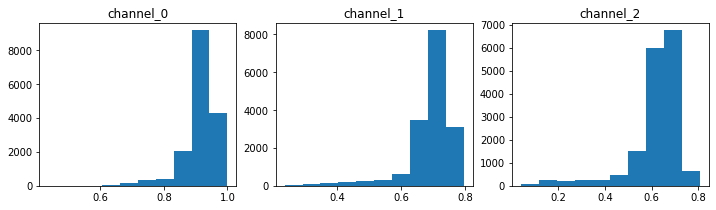

In [ ]:
skin_sample_ch0_np, skin_sample_ch1_np, skin_sample_ch2_np = get_sample_distributions_per_channel(img, mask_inpain, lesion_size)
fig, ax = plt.subplots(1,3, figsize=(12,3))
ax[0].hist(skin_sample_ch0_np); ax[0].set_title('channel_0')
ax[1].hist(skin_sample_ch1_np); ax[1].set_title('channel_1')
ax[2].hist(skin_sample_ch2_np); ax[2].set_title('channel_2');

In [ ]:
# if local
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == 'cuda':
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
# if cloud
# dtype = torch.cuda.FloatTensor
PLOT = True
torch.cuda.empty_cache()
skin_sample_ch0 = torch.tensor(np.asarray(skin_sample_ch0_np)).type(dtype)
skin_sample_ch1 = torch.tensor(np.asarray(skin_sample_ch1_np)).type(dtype)
skin_sample_ch2 = torch.tensor(np.asarray(skin_sample_ch2_np)).type(dtype)

In [ ]:
def closure():
    global i
    images_all = []
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
    out = net(net_input)
    
    # ussing KL per channel
    mask_skin = mask_var[0]
    mask_lesion = -mask_skin+1
    out_ch = torch.squeeze(out)
    lesion_only_ch0 =  out_ch[0][torch.where((out_ch[0] * mask_lesion)>0)]
    lesion_only_ch1 =  out_ch[1][torch.where((out_ch[1] * mask_lesion)>0)]
    lesion_only_ch2 =  out_ch[2][torch.where((out_ch[2] * mask_lesion)>0)]
    kl_loss_ch0 = KL(torch.log_softmax(lesion_only_ch0, dim=0), torch.softmax(skin_sample_ch0, dim=0))
    kl_loss_ch1 = KL(torch.log_softmax(lesion_only_ch1, dim=0), torch.softmax(skin_sample_ch1, dim=0))
    kl_loss_ch2 = KL(torch.log_softmax(lesion_only_ch2, dim=0), torch.softmax(skin_sample_ch2, dim=0))
    
    total_loss = mse(out * mask_var, img_var * mask_var) + kl_loss_ch0 + kl_loss_ch2 + kl_loss_ch2
    total_loss.backward()
        
    print ('Iteration %05d    Loss %.12f' % (i, total_loss.item()), '\r', end='')
    
    if  PLOT:
        out_np = torch_to_np(out)
        image_to_save = out_np
        images_all.append(image_to_save)
        
    i += 1    

    return total_loss, images_all

In [ ]:
pad = 'zero' 
OPT_OVER = 'net'
OPTIMIZER = 'adam'
INPUT = 'noise'
input_depth = channels_input 
num_iter = run_epochs 
param_noise = True
show_every = 500
reg_noise_std = 0.1
LR = 0.01
restart_i = 0
restart = True
params = f'LR={LR}_noise={reg_noise_std}'

In [ ]:
mse_error_all = []
img_np = img
img_mask_np = mask_inpain

In [ ]:
while restart == True:
    start = time.time()
    print(f'training initialization {restart_i} with LR = {LR:.12f}')
    restart_i += 1
    # Loss
    mse = torch.nn.MSELoss().type(dtype)
    KL = nn.KLDivLoss()
    img_var = np_to_torch(img_np).type(dtype)
    mask_var = np_to_torch(img_mask_np).type(dtype)

    net = skip(input_depth, img_np.shape[0], 
            num_channels_down = channels_layers, 
            num_channels_up   = channels_layers[::-1], 
            num_channels_skip = channels_skip, 
            upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3, 
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    net = net.type(dtype)        
    net_input = get_noise2(input_depth, INPUT, img_np.shape[1:], noise_type='n').type(dtype)

    i = 0
    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()
    print(f'noise: {type(noise.detach().cpu().numpy())}, {np.shape(noise.detach().cpu().numpy())}, {np.min(noise.detach().cpu().numpy()), np.mean(noise.detach().cpu().numpy()), np.max(noise.detach().cpu().numpy())}')

    p = get_params(OPT_OVER, net, net_input)
    mse_error, images_generated_all, best_iter, restart = optimize_melanoma_v1(OPTIMIZER, p, closure, LR, num_iter, show_every, path_img_dest, restart, annealing=True, lr_finder_flag=False)
    
    mse_error = [i.detach().cpu().numpy() for i in mse_error]

    if restart_i % 10 == 0: # reduce lr if the network is not learning with the initializations
        LR /= 1.2
    if restart_i == 30: # if the network cannot be trained continue (might not act on for loop!!)
        continue

training initialization 0 with LR = 0.010000000000
using get_noise2


  0%|          | 0/51 [00:00<?, ?it/s]

noise: <class 'numpy.ndarray'>, (1, 32, 512, 512), (-0.53264946, 3.0437857e-05, 0.5106273)
0


  2%|▏         | 1/51 [00:07<06:11,  7.44s/it]

1


  4%|▍         | 2/51 [00:13<05:39,  6.93s/it]

2


  6%|▌         | 3/51 [00:17<04:55,  6.16s/it]

3


  8%|▊         | 4/51 [00:22<04:25,  5.65s/it]

4


 10%|▉         | 5/51 [00:26<04:00,  5.24s/it]

5


 12%|█▏        | 6/51 [00:30<03:39,  4.87s/it]

6


 14%|█▎        | 7/51 [00:34<03:25,  4.67s/it]

7


 16%|█▌        | 8/51 [00:38<03:12,  4.49s/it]

8


 18%|█▊        | 9/51 [00:42<03:04,  4.38s/it]

9


 20%|█▉        | 10/51 [00:46<02:54,  4.25s/it]

10


 22%|██▏       | 11/51 [00:50<02:46,  4.16s/it]

11


 24%|██▎       | 12/51 [00:55<02:55,  4.49s/it]

12


 25%|██▌       | 13/51 [01:01<02:59,  4.72s/it]

13


 27%|██▋       | 14/51 [01:05<02:47,  4.52s/it]

14


 29%|██▉       | 15/51 [01:09<02:37,  4.37s/it]

15


 31%|███▏      | 16/51 [01:12<02:24,  4.13s/it]

16


 33%|███▎      | 17/51 [01:17<02:24,  4.26s/it]

17


 35%|███▌      | 18/51 [01:22<02:29,  4.53s/it]

18


 37%|███▋      | 19/51 [01:26<02:19,  4.35s/it]

19


 39%|███▉      | 20/51 [01:29<02:07,  4.10s/it]

20


 41%|████      | 21/51 [01:33<01:59,  3.97s/it]

21


 43%|████▎     | 22/51 [01:37<01:58,  4.10s/it]

22


 45%|████▌     | 23/51 [01:41<01:52,  4.03s/it]

23


 47%|████▋     | 24/51 [01:45<01:49,  4.05s/it]

24


 49%|████▉     | 25/51 [01:50<01:48,  4.17s/it]

25


 51%|█████     | 26/51 [01:55<01:49,  4.39s/it]

26


 53%|█████▎    | 27/51 [01:59<01:40,  4.18s/it]

27


 55%|█████▍    | 28/51 [02:02<01:31,  3.96s/it]

28


 57%|█████▋    | 29/51 [02:05<01:23,  3.80s/it]

29


 59%|█████▉    | 30/51 [02:09<01:18,  3.74s/it]

30


 61%|██████    | 31/51 [02:15<01:29,  4.45s/it]

31


 63%|██████▎   | 32/51 [02:21<01:33,  4.93s/it]

32


 65%|██████▍   | 33/51 [02:25<01:22,  4.60s/it]

33


 67%|██████▋   | 34/51 [02:30<01:19,  4.69s/it]

34


 69%|██████▊   | 35/51 [02:34<01:10,  4.41s/it]

35


 71%|███████   | 36/51 [02:37<01:03,  4.22s/it]

36


 73%|███████▎  | 37/51 [02:42<00:58,  4.19s/it]

37


 75%|███████▍  | 38/51 [02:48<01:02,  4.84s/it]

38


 76%|███████▋  | 39/51 [02:53<00:58,  4.84s/it]

39


 78%|███████▊  | 40/51 [02:57<00:50,  4.59s/it]

40


 80%|████████  | 41/51 [03:00<00:42,  4.26s/it]

41


 82%|████████▏ | 42/51 [03:04<00:37,  4.20s/it]

42


 84%|████████▍ | 43/51 [03:08<00:32,  4.05s/it]

43


 86%|████████▋ | 44/51 [03:12<00:28,  4.05s/it]

44


 88%|████████▊ | 45/51 [03:16<00:24,  4.16s/it]

45


 90%|█████████ | 46/51 [03:21<00:21,  4.34s/it]

46


 92%|█████████▏| 47/51 [03:26<00:18,  4.52s/it]

47


 94%|█████████▍| 48/51 [03:32<00:14,  5.00s/it]

48


 96%|█████████▌| 49/51 [03:36<00:09,  4.61s/it]

49


 98%|█████████▊| 50/51 [03:40<00:04,  4.36s/it]

50


100%|██████████| 51/51 [03:44<00:00,  4.41s/it]

In [ ]:
save_epochs = [1,2,3,4,5] #[10,20,40,80,100]
images=[]
images_raw=[]
for i in save_epochs:
    img_tmp = images_generated_all[i] * mask_lesion + img *  mask_inpain
    img_tmp = np.swapaxes(img_tmp[0], 0,1); img_tmp = np.swapaxes(img_tmp, 1,2)
    images.append(img_tmp)
    raw_tmp = images_generated_all[i]
    raw_tmp = np.swapaxes(raw_tmp[0], 0,1); raw_tmp = np.swapaxes(raw_tmp, 1,2)
    images_raw.append(raw_tmp)

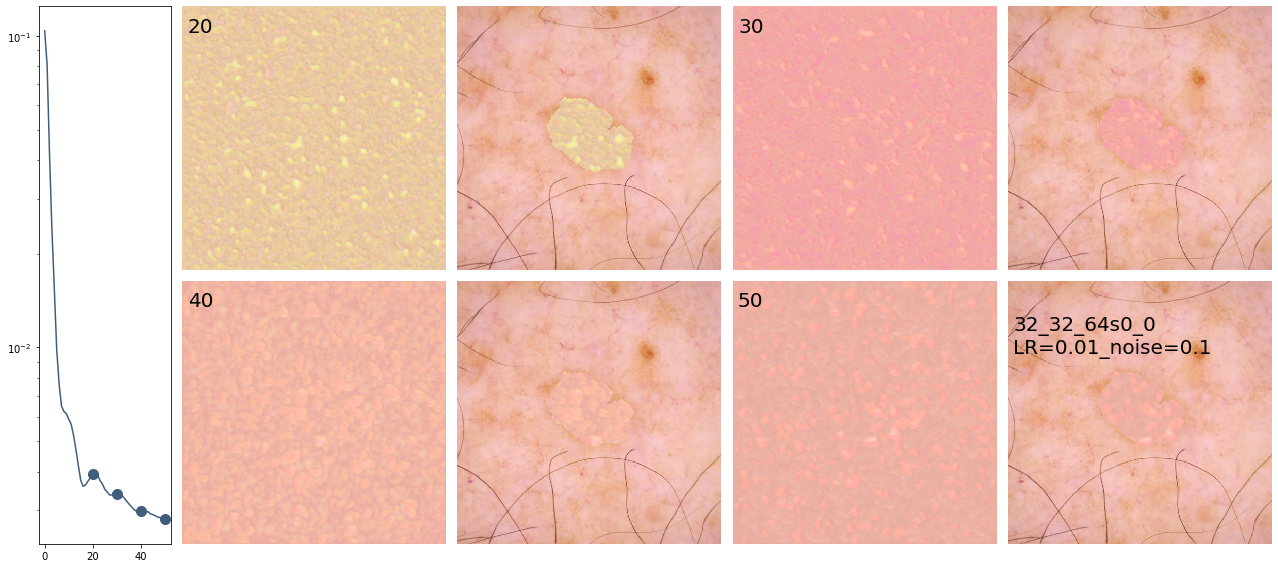

In [ ]:
plot_inpaints_pairs(mse_error, images_raw, images, save_epochs, filename, name_for_fig, params)

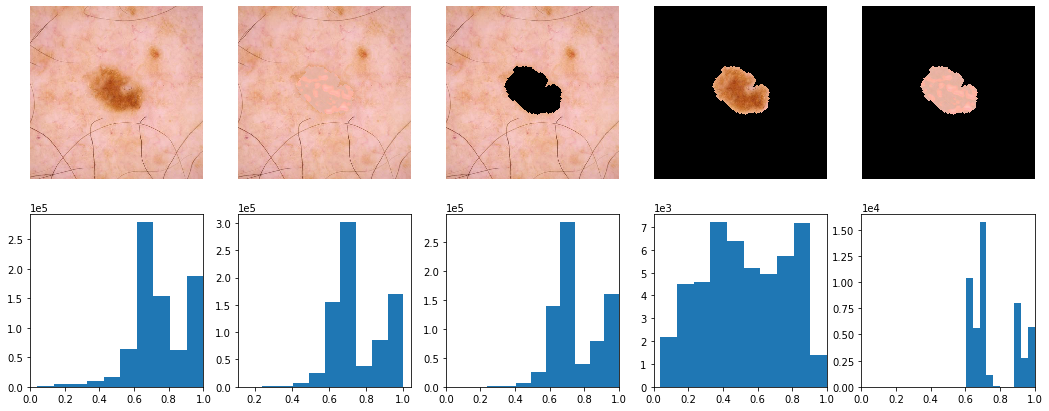

In [ ]:
plot_distributions(img, images, mask_var)

In [ ]:
# save individual images
image_denorm = [denormalizePatches(i) for i in images]
image_raw_denorm = [denormalizePatches(i) for i in images_raw]
for (img_to_save, epoch_to_save) in zip(image_denorm, save_epochs):
    im2save = Image.fromarray(img_to_save.astype(np.uint8))
    im2save.save(f'{path_img_dest}final/{filename}_{name}_{epoch_to_save:04d}.png')
for (img_to_save, epoch_to_save) in zip(image_raw_denorm, save_epochs):
    im2save = Image.fromarray(img_to_save.astype(np.uint8))
    im2save.save(f'{path_img_dest}raw/{filename}_{name}_{epoch_to_save:04d}.png')
np.save(f'{path_img_dest}mse/{filename}_{name}.npy', mse_error)